In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import os
import PIL
import PIL.Image
import sys
import glob
from pathlib import Path


# Get the path of the dataset
os.chdir(sys.path[0])
working_directory = os.getcwd()
print(working_directory)
data_path = Path(working_directory + r"/dataset/IMG_CLASSES")

# Count the number of images within the  dataset
image_count = len(list(data_path.glob('*/*.jpg')))
print("The number of images in the dataset is " + str(image_count))

# Batch size and dimensions
batch_size = 64
IMG_SIZE = (260,260)

#Assigning the data splits and seed
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

d:\VIP_Project
The number of images in the dataset is 27153
Found 27153 files belonging to 10 classes.
Using 21723 files for training.
Found 27153 files belonging to 10 classes.
Using 5430 files for validation.


In [2]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
])

In [3]:
#transfer learning using resnet152
#Preprocessing the data
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
  monitor='val_loss', min_delta=0.0001, patience=3)

In [5]:
IMG_SIZE = (260,260)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.efficientnet.EfficientNetB2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=10
                                              )

#freeze all the layer
for layer in base_model.layers:
    layer.trainable = False

In [6]:
base_model.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 260, 260, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 260, 260, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 261, 261, 3)  0           ['normalization[0][0

In [7]:
inputs = tf.keras.Input(shape=(260,260, 3))

x = preprocess_input(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
            
x = layers.Flatten()(x)
x = layers.Dense(256, activation ='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(10, activation ='softmax')(x)


head_model = tf.keras.Model(inputs,predictions)
head_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])


head_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 260, 260, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 260, 260, 3)       0         
                                                                 
 efficientnetb2 (Functional)  (None, 9, 9, 1408)       7768569   
                                                                 
 flatten (Flatten)           (None, 114048)            0         
                                                                 
 dense (Dense)               (None, 256)               29196544  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570  

In [8]:
history = head_model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset,
                    batch_size = 64
                   )

Epoch 1/5
340/340 [==============================] - 157s 406ms/step - loss: 2.2173 - accuracy: 0.3985 - val_loss: 1.3122 - val_accuracy: 0.4853
Epoch 2/5
340/340 [==============================] - 132s 386ms/step - loss: 1.4696 - accuracy: 0.4526 - val_loss: 1.1568 - val_accuracy: 0.5215
Epoch 3/5
340/340 [==============================] - 190s 556ms/step - loss: 1.3627 - accuracy: 0.4765 - val_loss: 1.1216 - val_accuracy: 0.5267
Epoch 4/5
340/340 [==============================] - 181s 530ms/step - loss: 1.3185 - accuracy: 0.4933 - val_loss: 1.0856 - val_accuracy: 0.5589
Epoch 5/5
340/340 [==============================] - 166s 486ms/step - loss: 1.2902 - accuracy: 0.4973 - val_loss: 1.0668 - val_accuracy: 0.5948


In [9]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [10]:
for layer in base_model.layers[-30:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

head_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [11]:
history_unfreeze = head_model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    batch_size = 64,
                    callbacks = [learning_rate_reduction]
)

Epoch 1/30
340/340 [==============================] - 195s 539ms/step - loss: 1.1834 - accuracy: 0.5262 - val_loss: 0.9876 - val_accuracy: 0.5860 - lr: 1.0000e-04
Epoch 2/30
340/340 [==============================] - 195s 570ms/step - loss: 1.1278 - accuracy: 0.5457 - val_loss: 0.9372 - val_accuracy: 0.6210 - lr: 1.0000e-04
Epoch 3/30
340/340 [==============================] - 189s 554ms/step - loss: 1.0953 - accuracy: 0.5550 - val_loss: 0.9429 - val_accuracy: 0.6269 - lr: 1.0000e-04
Epoch 4/30
340/340 [==============================] - 188s 550ms/step - loss: 1.0592 - accuracy: 0.5723 - val_loss: 0.8931 - val_accuracy: 0.6490 - lr: 1.0000e-04
Epoch 5/30
340/340 [==============================] - 194s 569ms/step - loss: 1.0234 - accuracy: 0.5847 - val_loss: 0.9210 - val_accuracy: 0.6370 - lr: 1.0000e-04
Epoch 6/30
340/340 [==============================] - 188s 552ms/step - loss: 0.9942 - accuracy: 0.5984 - val_loss: 0.8276 - val_accuracy: 0.6788 - lr: 1.0000e-04
Epoch 7/30
340/340 [==

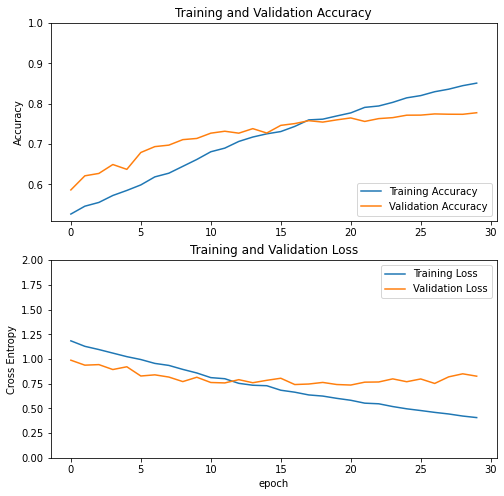

In [14]:
acc = history_unfreeze.history['accuracy']
val_acc = history_unfreeze.history['val_accuracy']

loss = history_unfreeze.history['loss']
val_loss = history_unfreeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('efficient_netB2 score.png')
plt.show()

head_model.save("efficient_netB2.h5")

In [15]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_unfreeze.history) 

# save to json:  
hist_json_file = 'efficient_netB2_finetune_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
hist_csv_file = 'efficient_netB2_finetune_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)